In [2]:
import pandas as pd
import os

# Extracting features which we think is useful for the network

In [4]:
# data = pd.read_csv('Speed Dating Data(clean).csv', delimiter=',', encoding='ISO-8859-1')
data = pd.read_csv('Speed Dating Data(clean).csv', delimiter=',', encoding='ISO-8859-1')


FileNotFoundError: [Errno 2] File b'Speed Dating Data(clean).csv' does not exist: b'Speed Dating Data(clean).csv'

In [ ]:
extracted = data.copy()

extracted= data[['gender', 'match', 'samerace', 'age_o', 'dec_o', 'field_cd', 'like_o', 'shar_o', 'sinc_o', 'race_o', 'intel_o', 'attr_o', 'amb_o', 'fun_o', 'age', 'race', 'imprace', 'imprelig', 'exphappy', 'career_c', 'dec']]
extracted.to_csv('Extracted_features.csv')
data.to_csv('Extracted_features(1).csv')


In [ ]:
extracted

# Creating the network and training the dataset

2667
[   0    1    2 ... 2664 2665 2666]
iter 0: train error 0.682165
iter 0: test error 0.686319
iter 0: training accuracy 0.588676
iter 0: test accuracy 0.569056 

iter 100: train error 0.631271
iter 100: test error 0.635547
iter 100: training accuracy 0.633296
iter 100: test accuracy 0.623252 

iter 200: train error 0.57598
iter 200: test error 0.574678
iter 200: training accuracy 0.700037
iter 200: test accuracy 0.712413 

iter 300: train error 0.535063
iter 300: test error 0.527851
iter 300: training accuracy 0.732283
iter 300: test accuracy 0.73951 

iter 400: train error 0.514246
iter 400: test error 0.503246
iter 400: training accuracy 0.741657
iter 400: test accuracy 0.748252 

iter 500: train error 0.502382
iter 500: test error 0.490026
iter 500: training accuracy 0.752531
iter 500: test accuracy 0.751748 

iter 600: train error 0.494835
iter 600: test error 0.481722
iter 600: training accuracy 0.758905
iter 600: test accuracy 0.755245 

iter 700: train error 0.489664
iter 70

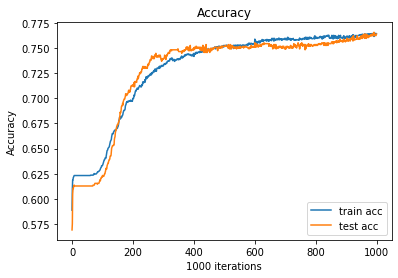

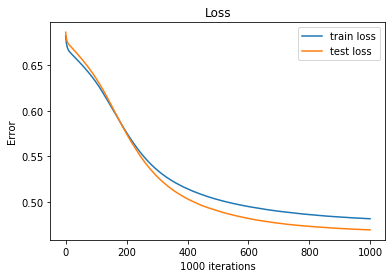

In [52]:
import tensorflow as tf
import numpy as np
import math
import os
import pylab as plt
import impyute.imputation.cs.em as em
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

%matplotlib inline

if not os.path.isdir('figures'):
    print('creating the figures folder')
    os.makedirs('figures')
    
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# scale data
def scale(X, X_min, X_max):
    return (X - X_min) / (X_max - X_min)

NUM_FEATURES = 24
NUM_CLASSES = 2

learning_rate = 0.001
epochs = 1000
batch_size = 32
num_neurons = 20
SEED = 10

filling_values = 0

np.random.seed(SEED)


def fnn(x, hidden_units):
    # Hidden 1
    h_weights = tf.Variable(
        tf.random.truncated_normal([NUM_FEATURES, hidden_units], stddev=1.0 / math.sqrt(float(NUM_FEATURES))),
        name='weights')
    h_biases = tf.Variable(tf.zeros([hidden_units]), name='biases')

    h = tf.nn.relu(tf.matmul(x, h_weights) + h_biases)

    # Output layer
    weights = tf.Variable(
        tf.random.truncated_normal([hidden_units, NUM_CLASSES], stddev=1.0 / math.sqrt(float(NUM_FEATURES))),
        name='weights')
    biases = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases')
    logits = tf.matmul(h, weights) + biases

    return logits, h_weights, weights


def main():
    # read train data
    train_input = np.genfromtxt('male(final).csv', delimiter=',')
    trainX, train_Y = train_input[1:, 1:25], train_input[1:, -1].astype(int)
    
    # handle missing values in trainX and then scale it
#     trainX = em(trainX_, loops=50)
    trainX = scale(trainX, np.min(trainX, axis=0), np.max(trainX, axis=0))
    
    trainY = np.zeros((train_Y.shape[0], NUM_CLASSES))
    trainY[np.arange(train_Y.shape[0]), train_Y - 1] = 1  # one hot matrix
    trainX, testX, trainY, testY = train_test_split(trainX, trainY, test_size=0.3, shuffle=True)
    
    n = trainX.shape[0]
    print(n)

    # Create the model
    x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
    y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

    logits, h_weights, weights = fnn(x, num_neurons)

    # Build the graph for the deep net
    y = tf.nn.softmax(logits=logits)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
    beta = tf.constant(1e-9)
    L2_regularization = tf.nn.l2_loss(h_weights) + tf.nn.l2_loss(weights)
    loss = tf.reduce_mean(cross_entropy + beta * L2_regularization)

    # Create the gradient descent optimizer with the given learning rate.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)

    correct_prediction = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1)), tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)
    
    # Training the network
    N = len(trainX)
    idx = np.arange(N)
    print(idx)
    converged = False
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        train_acc = []
        test_acc = []
        train_err = []
        test_err = []

        for i in range(epochs):
            np.random.shuffle(idx)
            trainX = trainX[idx]
            trainY = trainY[idx]

            for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
                train_op.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})

            
            train_err.append(loss.eval(feed_dict={x: trainX, y_: trainY}))
            test_err.append(loss.eval(feed_dict={x: testX, y_: testY}))
            
            train_acc.append(accuracy.eval(feed_dict={x: trainX, y_: trainY}))
            test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))

            if i % 100 == 0:
                print('iter %d: train error %g' % (i, train_err[i]))
                print('iter %d: test error %g' % (i, test_err[i]))
                print('iter %d: training accuracy %g' % (i, train_acc[i]))
                print('iter %d: test accuracy %g' % (i, test_acc[i]), '\n')
            if not converged and i > 100 and test_err[i - 100] - test_err[i] < 0.0001:
                print("converged at iteration ", i)
                converged = True
         
        pred = sess.run(y, feed_dict={x:testX})
#         print('predicted', pred, 'actual', testY)
        
    # plot learning curves
    plt.figure(1)
    plt.plot(range(epochs), train_acc)
    plt.plot(range(epochs), test_acc)
    plt.legend(["train acc", "test acc"], loc='lower right')
    plt.xlabel(str(epochs) + ' iterations')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.savefig('./figures/Training_Acc(female imputed).png')

    plt.figure(2)
    plt.plot(range(epochs), train_err)
    plt.plot(range(epochs), test_err)
    plt.legend(["train loss", "test loss"], loc='upper right')
    plt.xlabel(str(epochs) + ' iterations')
    plt.ylabel('Error')
    plt.title('Loss')
    plt.savefig('./figures/Testing_Acc(female inputed).png')

    plt.show()
    
    return pred, testY, testX

if __name__ == '__main__':
    pred, testY, testX = main()

In [53]:
import pandas as pd

df = pd.read_csv('male(final).csv')
df.columns

Index(['gender', 'samerace', 'age_o', 'race_o', 'pf_o_att', 'pf_o_sin',
       'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha', 'attr_o', 'sinc_o',
       'shar_o', 'amb_o', 'fun_o', 'intel_o', 'like_o', 'prob_o', 'met_o',
       'age', 'field_cd', 'race', 'imprace', 'career_c', 'income', 'dec_o'],
      dtype='object')

In [54]:
len(testX[0])
columns=['gender', 'samerace', 'age_o', 'race_o', 'pf_o_att', 'pf_o_sin',
       'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha', 'attr_o', 'sinc_o',
       'shar_o', 'amb_o', 'fun_o', 'intel_o', 'like_o', 'prob_o', 'met_o',
       'age', 'field_cd', 'race', 'imprace', 'career_c', 'income']
len(columns)

24

In [57]:
import pandas as pd

x = pd.DataFrame(data=testX, columns=['samerace', 'age_o', 'race_o', 'pf_o_att', 'pf_o_sin',
       'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha', 'attr_o', 'sinc_o',
       'shar_o', 'amb_o', 'fun_o', 'intel_o', 'like_o', 'prob_o', 'met_o',
       'age', 'field_cd', 'race', 'imprace', 'career_c', 'income'])

x_unscale = x.loc[:, "attr_o":"like_o"].apply(lambda x: x*10)
del x['race_o']

y_p = pd.DataFrame(data=np.argmax(pred, axis=1).tolist(), columns=['dec_m'])
y_a = pd.DataFrame(data=np.argmax(testY, axis=1).tolist(), columns=['dec_a'])

In [58]:
df_full = pd.merge(x_unscale, y_p, left_index=True, right_index=True)
df_actual = pd.merge(x_unscale, y_a, left_index=True, right_index=True)

yes_model = df_full[df_full.dec_m == 1]
no_model = df_full[df_full.dec_m == 0]

yes_actual = df_actual[df_actual.dec_a == 1]
no_actual = df_actual[df_actual.dec_a == 0]

yes_model_mean = yes_model.groupby('dec_m').mean().loc[:,"attr_o":"like_o"]
yes_actual_mean = yes_actual.groupby('dec_a').mean().loc[:,"attr_o":"like_o"]


no_model_mean = no_model.groupby('dec_m').mean().loc[:,"attr_o":"like_o"]
no_actual_mean = no_actual.groupby('dec_a').mean().loc[:,"attr_o":"like_o"]

In [59]:
x_unscale.columns

Index(['attr_o', 'sinc_o', 'shar_o', 'amb_o', 'fun_o', 'intel_o', 'like_o'], dtype='object')

In [60]:
x_unscale_array = x_unscale.values

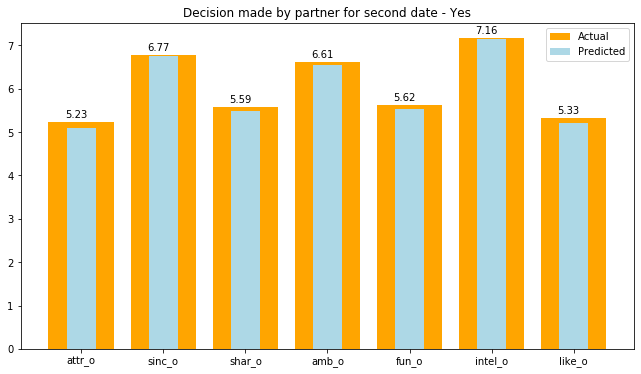

In [62]:
l = ['attr_o', 'sinc_o', 'shar_o', 'amb_o', 'fun_o', 'intel_o', 'like_o']


fig, ax = plt.subplots(figsize=(11,6))

ax.bar(l, yes_actual_mean.values[0], color='orange', label='Actual')
ax.bar(l, yes_model_mean.values[0], color='lightblue', width=0.35, label='Predicted')
ax.legend()
diff = [yes_actual_mean.values[0][i]-yes_model_mean.values[0][i] for i in range(len(yes_actual_mean.values[0]))]

i =0

for x1,y1 in enumerate(yes_actual_mean.values[0]):
#     ax.text(x1-0.2,y1+0.1, "+%.2f"%diff[i], color= "black")
    ax.text(x1-0.2,y1+0.1, "%.2f"%y1, color= "black")
    i+=1
    
plt.title("Decision made by partner for second date - Yes")    
plt.show()

<Figure size 432x288 with 0 Axes>

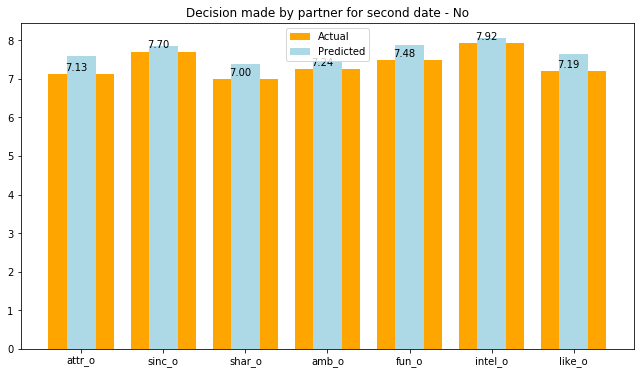

In [63]:
l = ['attr_o', 'sinc_o', 'shar_o', 'amb_o', 'fun_o', 'intel_o', 'like_o']

plt.clf()
fig, ax = plt.subplots(figsize=(11,6))

ax.bar(l, no_actual_mean.values[0], color='orange', label='Actual')
ax.bar(l, no_model_mean.values[0], color='lightblue', width=0.35, label='Predicted')
ax.legend()
diff = [no_actual_mean.values[0][i]-no_model_mean.values[0][i] for i in range(len(no_actual_mean.values[0]))]

i =0

for x1,y1 in enumerate(no_actual_mean.values[0]):
#     ax.text(x1-0.2,y1+0.1, "%.2f"%diff[i], color= "black")
    ax.text(x1-0.2,y1+0.1, "%.2f"%y1, color= "black")
    i+=1
    
plt.title("Decision made by partner for second date - No")    
plt.show()

# Confusion matrix for our network

In [64]:
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(actual, predict_class)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, (i+0.5)*0.5, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Plotting the Confusion Matrix

Confusion matrix, without normalization
[[283 160]
 [110 591]]
Normalized confusion matrix
[[0.64 0.36]
 [0.16 0.84]]


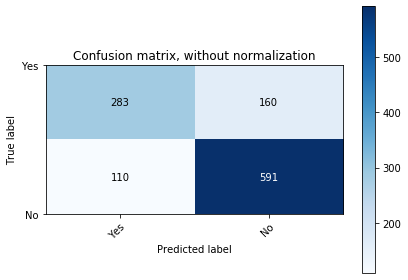

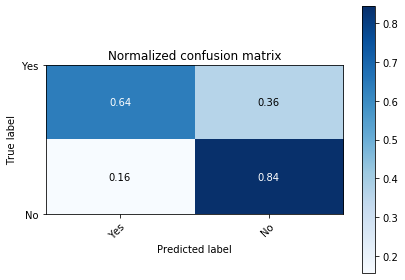

In [65]:
# Converting np array to list for confusion matrix
predict_class = np.argmax(pred, axis=1).tolist()
actual = np.argmax(testY, axis=1).tolist()

np.set_printoptions(precision=2)

class_names = ['Yes', 'No']

# Plot non-normalized confusion matrix
plot_confusion_matrix(actual, predict_class, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.savefig('./figures/non-normalised(female imputed).png')

# Plot normalized confusion matrix
plot_confusion_matrix(actual, predict_class, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('./figures/normalised(female imputed).png')

plt.show()

# Handle missing values

In [31]:
import pandas as pd
import numpy as np
import impyute.imputation.cs.em as em

# read train data
train_input = np.genfromtxt('train_new.csv', delimiter=',')
trainX_, train_Y = train_input[1:, :19], train_input[1:, -1]

# Take out attribute columns career_c columns
attr_col, career = trainX_[:, :18], trainX_[:, -1]
# handle missing values in attributes feature and career
#trainX = em(trainX_, loops=50)

OSError: train_new.csv not found.

In [ ]:
attr_col

In [ ]:
career

In [ ]:
attr_col = np.nan_to_num(attr_col)

In [ ]:
attr_col

In [ ]:
half_clean = np.column_stack((attr_col, career))

In [ ]:
full_clean = np.nan_to_num(half_clean, -1.0)

In [ ]:
full_clean

In [ ]:
clean_df = np.column_stack((full_clean, train_Y))

In [ ]:
clean_df

In [ ]:
a = np.asarray(clean_df)
np.savetxt("clean_df(non_impute).csv", a, delimiter=",")

In [ ]:
full_clean2 = em(half_clean, loops=50)

In [ ]:
full_clean2

In [ ]:
clean_df2 = np.column_stack((full_clean2, train_Y))

In [ ]:
clean_df2

In [ ]:
a = np.asarray(clean_df2)
np.savetxt("clean_df(impute).csv", a, delimiter=",")

In [ ]:
df = pd.read_csv('clean_df(impute).csv')

In [ ]:
df.corr()

In [ ]:
df2 = pd.read_csv('train_new.csv')

In [ ]:
df2.corr()

In [ ]:
import seaborn as sns
ax = sns.heatmap(df2.corr(method='pearson'), vmin= -0.1, vmax = 1)


In [ ]:
train_input = np.genfromtxt('male(non_impute).csv', delimiter=',')
trainX, train_Y = train_input[1:, 1:19], train_input[1:, -1].astype(int)

# handle missing values in trainX and then scale it
#     trainX = em(trainX_, loops=50)
trainX = scale(trainX, np.min(trainX, axis=0), np.max(trainX, axis=0))

trainY = np.zeros((train_Y.shape[0], NUM_CLASSES))
trainY[np.arange(train_Y.shape[0]), train_Y - 1] = 1  # one hot matrix
trainX, testX, trainY, testY = train_test_split(trainX, trainY, test_size=0.3, shuffle=True)

In [ ]:
import pandas as pd
df = pd.read_csv('male(non_impute).csv')

In [ ]:
df.iloc[1:, 1:19]

In [ ]:
df = pd.read_csv('')